In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jun  2 11:09:55 2018

@author: Marcelo
"""
import numpy as np
from scipy import (signal)
from speccwt_class import (SpecCwt)

from teste_datas import (Spec)
# from cwt_graph import (CwtGraph)

from sys import platform
from platform import node
from readiecsp_func import readiecsp
from filebatch_class import (FileBatch)

# port (find_peaks, peak_widths, cwt, ricker, find_peaks_cwt)
from shann_entropy_func import (negtozero, nonullelements_cwtmatr)

from scipy.fftpack import (fft, ifft)
from scipy.stats import (entropy)
# from pathlib import Path, PurePath
import matplotlib.pyplot as plt
from scipy.optimize import (curve_fit, root)
from copy import deepcopy
# from numpy import cosh, zeros_like, mgrid, zeros
# from test_lists import seqmatch


In [2]:
def gaus(x):
    """Gaussian function.

    Args:
        x (float): variable.

    Returns:
        float: f(x), where f(x)=exp(-x**2).

    """
    return np.exp(-x**2)

In [3]:
# https://stackoverflow.com/questions/18326524/pass-tuple-as-input-argument-for-scipy-optimize-curve-fit
# https://pythontips.com/2013/08/04/args-and-kwargs-in-python-explained/
# ver tambem como usa keyword p0
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html#scipy.optimize.curve_fit

def expmaisk2(x,*args):
    locl = args
    d=locl[0]
    h=locl[1]
    k=locl[2]
    c=locl[3]
    print(13)
    print (args)
    return h*np.exp(k*(x-d))+c
    # return 29

def f(x, *p):
    return sum( [p[i]*x**i for i in range(len(p))] )

print(7)
print (expmaisk2(150.0, 50.0, 7.0, 0.02, 3.0))

aaa=f(2,0, 7, 34, 4, 3)
print(aaa)


7
13
(50.0, 7.0, 0.02, 3.0)
54.72339269251455
230


In [4]:
def fb(b, y):
    dy = y[-1]-y[0]
    s = 0
    sl = []
    for i in range(1,len(y)-2):
        s += y[i]-b[i-1]
        sl.append(s)
    f = []
    ln1 = y[-2]-y[-1]
    for i in range(0,len(y)-3):
        f.append( sl[i] / (sl[-1]+ln1) * dy + y[0] - b[i] )
    return f

In [5]:
# AQUI, finalmente a emenda de baseline
    
def bline_estimate( iny ):
    if len(iny) > 3:
        bi_ini = np.linspace( iny[0], iny[-1], len(iny) )[1:-2]
        fitres = root(fb, bi_ini, args=iny)
        listres = [ iny[0] ] + list(fitres.x) + iny[-2:]
    else:
        listres = iny
    return listres

In [6]:
def scan_spectrum( counts ):
    ww = 9                     # ww: window width
    chw = list( range(ww) )     
    
    scale = 1.0e3
    thres = 1.3
    
    nch = len( counts )

    # ch = list(range(nch))
    # covd00 = [ 0 for i in range(int(ww/2))]
    # covd01 = [ 0 for i in range(int(ww/2))]
    # covd11 = [ 0 for i in range(int(ww/2))]
    # for i in range( nch - ww):
    #     covd = np.cov( chw, counts[i:i+ww] )
    #     covd00.append( covd[0,0] )
    #     covd01.append( covd[0,1] )
    #     covd11.append( covd[1,1] )

    unc_counts = []
    for i in range( nch ):
        if counts[i] == 0:
            unc_counts.append( 2.0 ) # this is arbitrary...
        elif counts[i] == 1:
            unc_counts.append( 1.0 )
        else:
            unc_counts.append( np.sqrt( counts[i] ))

#    counts_weight = []
#    for i in range( nch ):
#        if counts[i] == 0:
#            counts_weight.append( 1.0 ) # this is arbitrary...
#        elif counts[i] == 1:
#            counts_weight.append( 1.0 )
#        else:
#           counts_weight.append( 1.0 / counts[i] )

    wlog = []
    for i in range( nch ):
        if counts[i] == 0:
            wlog.append( 1.0 ) # this is arbitrary...
        else:
            wlog.append( counts[i] )
    

    logcounts = []
    for i in range( nch ):
        if counts[i] <= 1:
            logcounts.append( 0.0 )
        else:
            logcounts.append( np.log( counts[i] ))

    # 2017-04-06 HERE: it's better apply poly fit to logcounts
    # In this case, adjust counts_weight properly
            
    # for i in range( nch - ww):
    #     wpoly.append( np.polyfit(x=chw, y=counts[i:i+ww], deg=2,
    #                              w=counts_weight[i:i+ww]) )
    # fill the beginning of list wpoly with dummy data
    # to synchronize list indices with channel numbers.
    
    dummy_coeffs = np.polyfit(x=chw, y = [0.0 for i in range(ww)], deg=2)
    wpoly = [ dummy_coeffs for i in range(int(ww/2))]
    for i in range( nch - ww):
        wpoly.append( np.polyfit(x=chw, y=logcounts[i:i+ww], deg=2,
                                 w=wlog[i:i+ww]) )
        
    coeff0 = [ p[0]    for p in wpoly ]
    coeff1 = [ p[1]    for p in wpoly ]
    coeff2 = [ p[2]    for p in wpoly ]

    wstd = [0 for i in range(int(ww/2))]
    for i in range( nch - ww):
        wmean = np.mean( counts[i:i+ww] )
        if wmean == 0:
            wstd.append(0)
        else:
            wstd.append( scale * np.std( counts[i:i+ww] ) / np.sqrt( wmean ) )
    
    # Define peaks regions (list "regions")
        
    regions = []
    limits = []
    inregion = False
    for i in range(len(wstd)):
        if not inregion and wstd[i] >= scale * thres:
            limits.append( i )
            inregion = True
        if inregion and wstd[i] < scale * thres:
            limits.append( i-1 )
            regions.append( limits )
            limits = []
            inregion = False
    
    # 2017-04-02 Integrar este trecho ao P.P.:
    # 
    # 2017-04-04: Connecting "close" regions
    # Let ...[a,b],[c,d]... consecutive elements in 'regions':
    #   When b-c <= something in 5...35, convert [a,b],[c,d] to [a,d].
    
    cazzo = deepcopy( regions )
    i = 0
    while i < len(cazzo)-1:
        if cazzo[i+1][0]-cazzo[i][1] <= 4:
            cazzo[i][1] = cazzo[i+1][1]
            cazzo.pop(i+1)
        else:
            i += 1
    regions = cazzo
    
    return nch, regions, wlog, wstd, coeff0, coeff1, coeff2
    
    # Fim do trecho a integrar


In [7]:

def calc_centroid( xforplot, net_forplot ):
    somaxnety = []
    for j in range(len(xforplot)):
        somaxnety.append( xforplot [j] * net_forplot [j] )
    centroid = sum( somaxnety ) / sum( net_forplot )
    return centroid

In [8]:
def def_bline_regions( nch, regions ):

    ######################################
    
    # Define baseline regions (list 'blin')

    blin = []
    blin.append( [ 0, regions[0][0] ] )
    for i in range(len(regions)-1):
        blin.append( [regions[i][1], regions[i+1][0]] )
    blin.append( [ regions[-1][1], nch-1 ] )
    return blin

In [9]:
def blines_fit( blin, counts, regions):

# Baseline fit between regions

    xbl = []
    ybl = []
    zbl = []
    for i in range(len(blin)):
        xbl.append( list( range( blin[i][0], blin[i][1]+1 ) ) )
        ybl.append( counts[ blin[i][0]:blin[i][1]+1 ] )
        zbl.append( np.polyfit(xbl[i], ybl[i], 2) )
    
    # Baseline estimating inside regions
    
    xrg = []
    yrg = []
    zrg = []
    for i in range(len(regions)):
        xrg.append( list( range( regions[i][0], regions[i][1]+1 ) ) )
        yrg.append( counts[ regions[i][0]:regions[i][1]+1 ] )
        deltay = yrg[i][-1] - yrg[i][0]
        sumy = sum( yrg[i] )
        cumy = 0
        zrgi = []
        for j in range( len( yrg[i] ) ):
            zrgi.append( yrg[i][0] )
        zrg.append( np.polyfit(xrg[i], yrg[i], 2) )
    
    return xbl, ybl, zbl, xrg, yrg, zrg


In [10]:
def perform_regions_fit( regions, zrg ):
    # regions fit
    regions_fit = []
    for i in range(len(regions)):
        xp = np.linspace(regions[i][0], regions[i][1], 50)
        # 2016-06-30: PAREI AQUI agora tem que fazer o ajuste gaussiano
        # so' coloquei polinomial para testar
        p = np.poly1d( zrg[i] )
        regions_fit.append( [xp, p(xp)] )
    return regions_fit

In [11]:
def perform_baselines_outside( blin, zbl ):
    # baselines outside regions fit
    baselines_outside = []
    for i in range(len(blin)):
        xp = np.linspace(blin[i][0], blin[i][1], 50)
        p = np.poly1d( zbl[i] )
        baselines_outside.append( [xp, p(xp)] )
    return baselines_outside


In [12]:
def preliminar_analysis ( regions, yrg, zbl ):
    n_valid_regions = 0
    # Number of CHannels on each side to eXTenD the ReGion
    nchxtdrg = 3
    baselines_inside = []
    net_regions = []
    netareas = []
    centroids = []
    for i in range( len(regions) ):
        if len( yrg[i] ) >= 3:
            n_valid_regions += 1
            # blest = bline_estimate( yrg[i] )
            p_bef = np.poly1d( zbl[i] )
            p_aft = np.poly1d( zbl[i+1] )     
            
            xforplot = list(
                range( regions[i][0]-nchxtdrg, regions[i][1]+nchxtdrg+1 ) )
            yforfit = list( p_bef( range(regions[i][0]-nchxtdrg,regions[i][0]) )) \
                    + yrg[i]                                                      \
                    + list( p_aft( range(regions[i][1]+1,regions[i][1]+nchxtdrg+1)) )
            bl_forplot = bline_estimate( yforfit )
    
            # blfit = yrg[i][:1] + list(blest.x) + yrg[i][-2:]
            # blfit = [ p_bef(blin[i][1]) ] + list(blest.x) + [ yrg[i][-2], p_aft( blin[i+1][0] ) ]
            # blfit = [ p_bef(blin[i][1]) ] + list(blest.x) + [ p_aft( blin[i+1][0] ) ] + [ p_aft( blin[i+1][0]-1 ) ]
            
            baselines_inside.append( [xforplot, bl_forplot] )
            
            net_forplot = []
            for j in range(len(yforfit)):
                net_forplot.append( yforfit[j] - bl_forplot[j] )
            net_regions.append( [xforplot, net_forplot] )    
            
            centroid = calc_centroid( xforplot, net_forplot )
            centroids.append( centroid )
                
            netareas.append( sum( net_forplot ))
    return n_valid_regions, baselines_inside, net_regions, netareas, centroids

In [13]:
def define_centroids( n_valid_regions, net_regions ):
    centrs = []
    for i in range( n_valid_regions ):
        ks = net_regions[i][0]
        cs = net_regions[i][1]
        sum_c = sum(cs)
        sum_kc = sum( [cs[j] * ks[j] for j in range(len(cs))] )
        centrs.append( sum_kc / sum_c )
    return centrs

In [14]:
def define_zis( n_valid_regions, net_regions, centrs ):
    zi = []
    for i in range( n_valid_regions ):
        ks = net_regions[i][0]
        cs = net_regions[i][1]
        k0 = centrs[i]
        xs = [ (ks[j] - k0)**2 for j in range(len(ks)) ]
        ys = []
        for j in range(len(cs)):
            if cs[j] > 1:
                ys.append( np.log(cs[j]) )
            else:
                ys.append( 0.0 )
        zi.append( np.polyfit( xs, ys, 1) )
    return zi


In [15]:
# 2017-03-08 Desabilitei, nao estah funcionando
# eliminate regions shorter than 3 channels, without changing "blin"

# newlist = []
# for i in range(len(regions)):
#     if regions[i][1]-regions[i][0] >= 2:
#         newlist.append( regions[i] )
# regions = [r for r in newlist]
# del newlist     

In [16]:
def define_stripped_regions( net_regions ):
    stripped_regions = []
    for i in range( len( net_regions )):
        ks = net_regions[i][0]
        cs = net_regions[i][1]
        newks = []
        newcs = []
        for j in range( len( ks )):
            if cs[j] > 2.0:
                newks.append( ks[j] )
                newcs.append( cs[j] )
            else:
                if len( newks ) >=3:
                    stripped_regions.append( [newks, newcs] )
                newks = []
                newcs = []
    return stripped_regions

In [17]:
def fit_peaks_width( stripped_regions, wlog ):
    peaks_width_fit = []
    new_centrs = []
    ### 2017-04-07 ATENCAO!!!! estou fazendo coisa duplicada!!!!
    for i in range( len( stripped_regions )):
        ks = stripped_regions[i][0]
        cs = stripped_regions[i][1]
        k0 = calc_centroid( ks, cs )
        new_centrs.append( k0 ) 
        xs = [ (ks[j] - k0)**2 for j in range(len(ks)) ]
        ys = [ np.log( cs[j] ) for j in range(len(cs)) ]
        peaks_width_fit.append( np.polyfit(x=xs, y=ys, deg=1, w=cs) )
    widths = [ -p[0] for p in peaks_width_fit ]
    heights = [ np.exp( p[1] ) for p in peaks_width_fit ]
    return new_centrs, widths, heights

In [18]:
cts_spc, lt_spc, rt_spc = readiecsp('../gamma/spectra/Diversos/CTP0704.IEC')

In [19]:
cts_spc, lt_spc, rt_spc = readiecsp(
    '../gamma/spectra/ALMERA-2017-3/ALM-17-3-#5_PreliA.IEC')

In [20]:
len(cts_spc)

8196

In [21]:
nch, regions, wlog, wstd, coeff0, coeff1, coeff2 = scan_spectrum( cts_spc )
blin = def_bline_regions(nch, regions)
xbl, ybl, zbl, xrg, yrg, zrg = blines_fit (blin, cts_spc, regions)

C:\Users\Marcelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
C:\Users\Marcelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
C:\Users\Marcelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
C:\Users\Marcelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
C:\Users\Marcelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
C:\Users\Marcelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
C:\Users\Marcelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
C:\Users\Marcelo\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RankWarning: Polyfit may be poorly conditioned
C:\Users\Marcelo\Anaconda3\lib\site-packages\ipykernel_l

In [22]:
n_valid_regions, baselines_inside, net_regions, netareas, centroids = preliminar_analysis(regions, yrg, zbl)

In [23]:
# Multipleto mais complexo do espectro: net_regions[7]
peaks7, _ = signal.find_peaks(net_regions[7][1], distance=5)
peaks7

array([  7,  16,  28,  39,  47,  53,  62,  71,  79,  93, 105, 111, 117,
       123], dtype=int64)

In [24]:
x_spc = np.linspace(0,len(cts_spc), len(cts_spc))

In [25]:
# PAREI AQUI 2018-Jun-15: corrigir isso.
soma = [[ca[0], [x+y for x,y in zip(ca[1],cb[1])] ]
        for ca, cb in zip(net_regions, baselines_inside)]

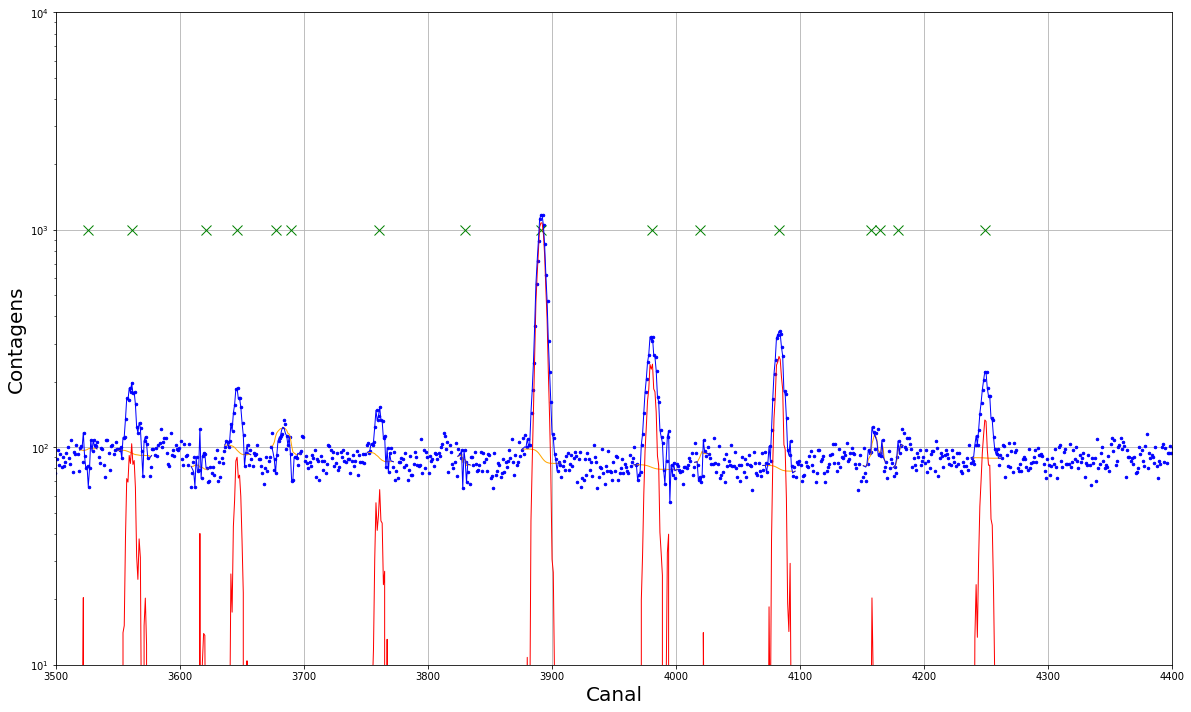

In [26]:
fig5, ax5 = plt.subplots(1, 1, figsize=(20,12))
ax5.grid(True)
ax5.set_xlim(3500, 4400)
ax5.set_ylim(1e1, 1e4)
ax5.set_xlabel('Canal', size=20)
ax5.set_ylabel('Contagens', size=20)
ax5.semilogy(x_spc, cts_spc, marker='.', markersize=5.0, color='blue', linewidth=0.0)
ax5.semilogy(centroids, [1e3]*len(centroids),
             marker='x', markersize=10.0, color='green', linewidth=0.0)
aaa = [ax5.semilogy(bl[0], bl[1], marker='', markersize=2.0, color='orange', linewidth=1.0) for bl in baselines_inside]
bbb = [ax5.semilogy(nr[0], nr[1], marker='', markersize=2.0, color='red',    linewidth=1.0) for nr in net_regions]
ccc = [ax5.semilogy(sm[0], sm[1], marker='', markersize=2.0, color='blue',    linewidth=1.0) for sm in soma]

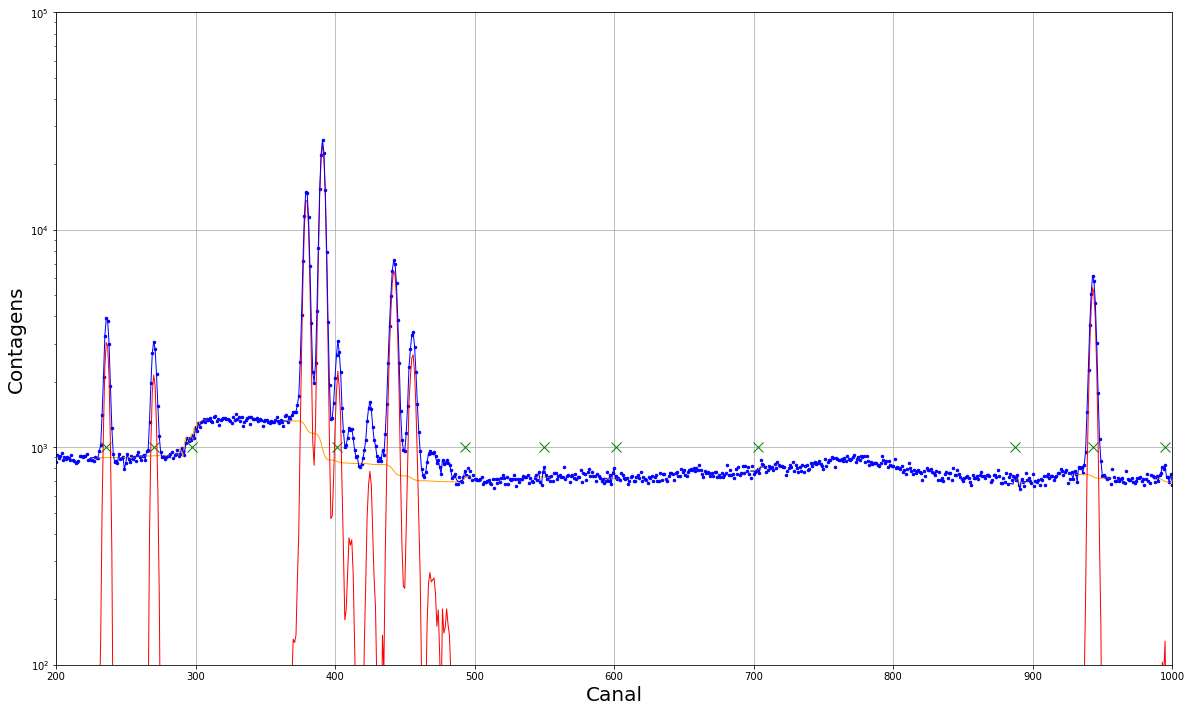

In [27]:
fig5, ax5 = plt.subplots(1, 1, figsize=(20,12))
ax5.grid(True)
ax5.set_xlim(200, 1000)
ax5.set_ylim(1e2, 1e5)
ax5.set_xlabel('Canal', size=20)
ax5.set_ylabel('Contagens', size=20)
ax5.semilogy(x_spc, cts_spc, marker='.', markersize=5.0, color='blue', linewidth=0.0)
ax5.semilogy(centroids, [1e3]*len(centroids),
             marker='x', markersize=10.0, color='green', linewidth=0.0)
aaa = [ax5.semilogy(bl[0], bl[1], marker='', markersize=2.0, color='orange', linewidth=1.0) for bl in baselines_inside]
bbb = [ax5.semilogy(nr[0], nr[1], marker='', markersize=2.0, color='red',    linewidth=1.0) for nr in net_regions]
ccc = [ax5.semilogy(sm[0], sm[1], marker='', markersize=2.0, color='blue',    linewidth=1.0) for sm in soma]

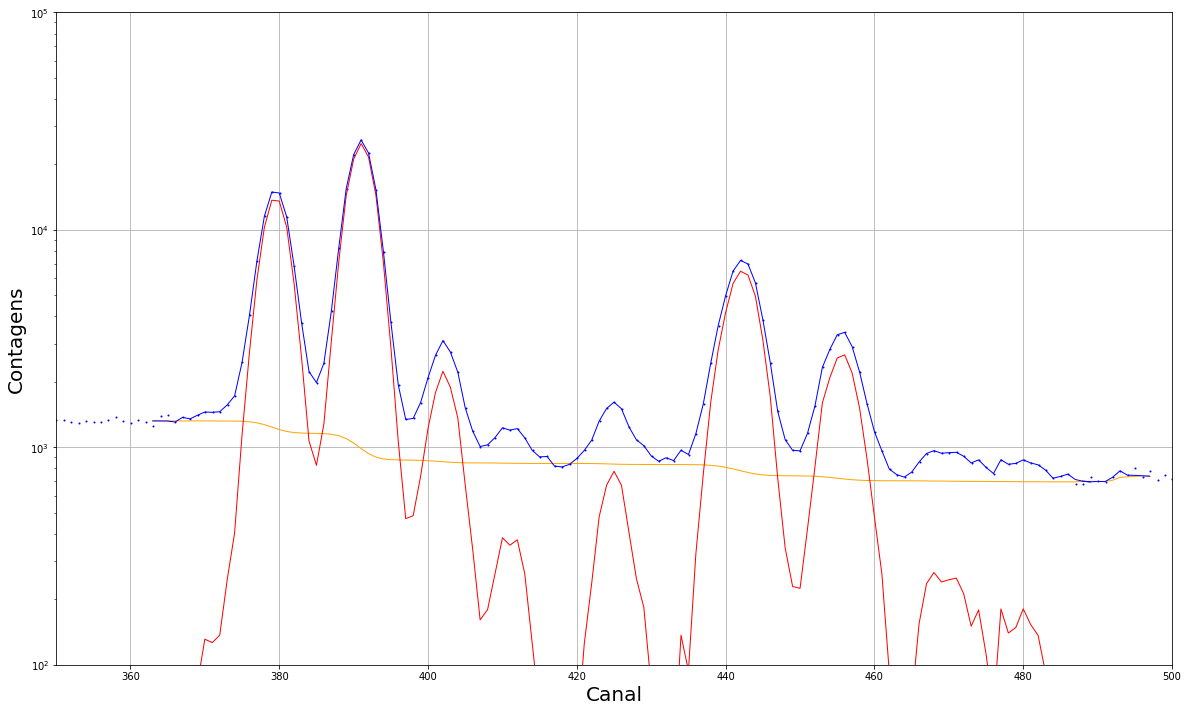

In [28]:
fig5, ax5 = plt.subplots(1, 1, figsize=(20,12))
ax5.grid(True)
ax5.set_xlim(350, 500)
ax5.set_ylim(1e2, 1e5)
ax5.set_xlabel('Canal', size=20)
ax5.set_ylabel('Contagens', size=20)
ax5.semilogy(x_spc, cts_spc, marker='.', markersize=2.0, color='blue', linewidth=0.0)
aaa = [ax5.semilogy(bl[0], bl[1], marker='', markersize=2.0, color='orange', linewidth=1.0) for bl in baselines_inside]
bbb = [ax5.semilogy(nr[0], nr[1], marker='', markersize=2.0, color='red',    linewidth=1.0) for nr in net_regions]
ccc = [ax5.semilogy(sm[0], sm[1], marker='', markersize=2.0, color='blue',    linewidth=1.0) for sm in soma]

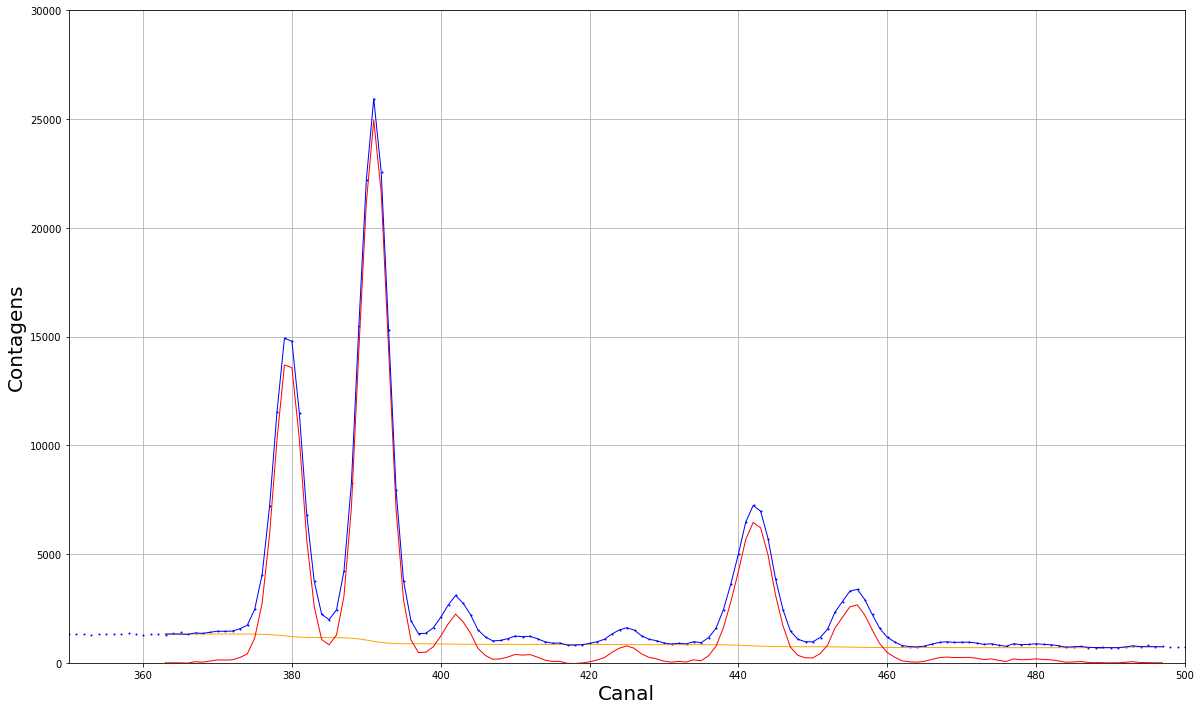

In [29]:
fig5, ax5 = plt.subplots(1, 1, figsize=(20,12))
ax5.grid(True)
ax5.set_xlim(350, 500)
ax5.set_ylim(0.0, 3e4)
ax5.set_xlabel('Canal', size=20)
ax5.set_ylabel('Contagens', size=20)
ax5.plot(x_spc, cts_spc, marker='.', markersize=2.0, color='blue', linewidth=0.0)
aaa = [ax5.plot(bl[0], bl[1], marker='', markersize=2.0, color='orange', linewidth=1.0) for bl in baselines_inside]
bbb = [ax5.plot(nr[0], nr[1], marker='', markersize=2.0, color='red',    linewidth=1.0) for nr in net_regions]
ccc = [ax5.plot(sm[0], sm[1], marker='', markersize=2.0, color='blue',    linewidth=1.0) for sm in soma]

In [30]:
# Fazendo de novo
# Multipleto mais complexo do espectro: net_regions[7]
peaks7, peaks7_props = signal.find_peaks(net_regions[7][1], distance=5, width=3)
peaks7

array([ 16,  28,  39,  47,  62,  79,  93, 105, 117], dtype=int64)

In [31]:
peaks7_props

{'prominences': array([12868.9206879 , 24973.10425034,  1769.43136045,   222.9679397 ,
          747.14087751,  6455.95320992,  2439.23945515,   237.72609536,
          119.54988957]),
 'left_bases': array([  3,   3,  34,  44,  55,  55,  87, 101, 113], dtype=int64),
 'right_bases': array([ 22,  55,  55,  55,  68, 125, 125, 125, 125], dtype=int64),
 'widths': array([4.34192443, 4.52586577, 3.78507384, 3.82492026, 4.35092631,
        5.6380277 , 5.31281936, 8.56593911, 5.84486442]),
 'width_heights': array([ 7261.41755867, 12471.04889942,  1354.66363173,   272.42069794,
          402.72181731,  3227.97660496,  1444.33207914,   146.94625151,
          121.04595857]),
 'left_ips': array([ 14.31045532,  25.73533657,  37.23141448,  46.0855634 ,
         59.68151006,  76.30521269,  89.8020605 , 102.91225693,
        113.50049812]),
 'right_ips': array([ 18.65237975,  30.26120234,  41.01648833,  49.91048366,
         64.03243637,  81.94324039,  95.11487987, 111.47819604,
        119.34536254])

In [32]:
wid = peaks7_props['widths']
wid

array([4.34192443, 4.52586577, 3.78507384, 3.82492026, 4.35092631,
       5.6380277 , 5.31281936, 8.56593911, 5.84486442])

In [33]:
2.0*np.sqrt(2.0*np.log(2.0))

2.3548200450309493

In [34]:
shs = 4.0*np.log(2.0) / wid**2.0
shs

array([0.14706893, 0.13535743, 0.19352485, 0.18951373, 0.146461  ,
       0.087223  , 0.09822801, 0.0377864 , 0.08115898])

In [35]:
cns = peaks7 + 363.0
cns

array([379., 391., 402., 410., 425., 442., 456., 468., 480.])

In [36]:
hes = np.asarray([net_regions[7][1][pk] for pk in peaks7])
hes

array([13695.87790262, 24957.60102459,  2239.37931195,   383.90466779,
         776.29225607,  6455.95320992,  2663.95180672,   265.80929919,
         180.82090335])

In [37]:
def gaussian(x,*p):
    ng = int( len(p) / 3)
    a = 0.0
    for i in range(ng):
        sh, he, cn = p[3*i+0], p[3*i+1], p[3*i+2]
        a += he*np.exp(-sh*(x-cn)**2)
    return a

In [38]:
# Definindo fun,c~ao com shs fixos
def g1(*shs):
    def g2(x, *hescns):
        pcompl = np.array([])
        ng = int( len(hescns) / 2)
        for i in range(ng):
            pcompl = np.append(pcompl, (shs[i], hescns[2*i+0], hescns[2*i+1]))
        return gaussian(x,*pcompl)
    return g2

In [39]:
gausinipars = np.array([shs, hes, cns]).transpose()
gausinipars

array([[1.47068930e-01, 1.36958779e+04, 3.79000000e+02],
       [1.35357434e-01, 2.49576010e+04, 3.91000000e+02],
       [1.93524850e-01, 2.23937931e+03, 4.02000000e+02],
       [1.89513731e-01, 3.83904668e+02, 4.10000000e+02],
       [1.46461000e-01, 7.76292256e+02, 4.25000000e+02],
       [8.72230043e-02, 6.45595321e+03, 4.42000000e+02],
       [9.82280114e-02, 2.66395181e+03, 4.56000000e+02],
       [3.77863973e-02, 2.65809299e+02, 4.68000000e+02],
       [8.11589778e-02, 1.80820903e+02, 4.80000000e+02]])

In [40]:
gausflat = gausinipars.flatten()
gausflat

array([1.47068930e-01, 1.36958779e+04, 3.79000000e+02, 1.35357434e-01,
       2.49576010e+04, 3.91000000e+02, 1.93524850e-01, 2.23937931e+03,
       4.02000000e+02, 1.89513731e-01, 3.83904668e+02, 4.10000000e+02,
       1.46461000e-01, 7.76292256e+02, 4.25000000e+02, 8.72230043e-02,
       6.45595321e+03, 4.42000000e+02, 9.82280114e-02, 2.66395181e+03,
       4.56000000e+02, 3.77863973e-02, 2.65809299e+02, 4.68000000e+02,
       8.11589778e-02, 1.80820903e+02, 4.80000000e+02])

In [41]:
popt_gauss1, pcov_gauss1 = curve_fit(gaussian, net_regions[7][0], net_regions[7][1],p0=gausflat)
popt_gauss1

array([1.46044413e-01, 1.38089578e+04, 3.79469028e+02, 1.42291699e-01,
       2.43200733e+04, 3.91006019e+02, 1.86684771e-01, 1.85296725e+03,
       4.02133443e+02, 2.58837361e-03, 4.69793283e+02, 3.91688743e+02,
       1.32595326e-01, 7.33896522e+02, 4.25038069e+02, 8.64822417e-02,
       6.47531786e+03, 4.42152642e+02, 8.89948901e-02, 2.65945900e+03,
       4.55536440e+02, 4.88353636e-02, 2.69346489e+02, 4.69516058e+02,
       5.10857740e-02, 1.65462447e+02, 4.79680167e+02])

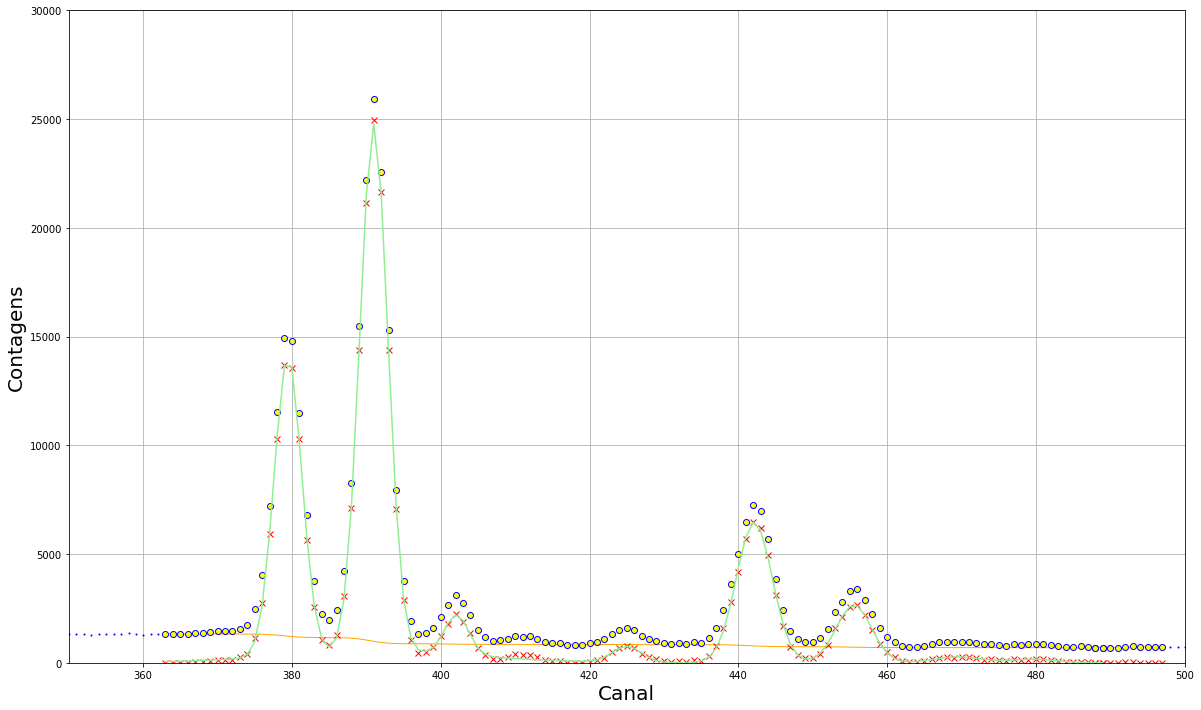

In [42]:
fig5, ax5 = plt.subplots(1, 1, figsize=(20,12))
ax5.grid(True)
ax5.set_xlim(350, 500)
ax5.set_ylim(0.0, 3e4)
ax5.set_xlabel('Canal', size=20)
ax5.set_ylabel('Contagens', size=20)
ax5.plot(x_spc, cts_spc, marker='.', markersize=2.0, color='blue', linewidth=0.0)
aaa = [ax5.plot(bl[0], bl[1], marker='', markersize=2.0, color='orange', linewidth=1.0) for bl in baselines_inside]
bbb = [ax5.plot(nr[0], nr[1], marker='x', color='red', linestyle='None') for nr in net_regions]
ccc = [ax5.plot(sm[0], sm[1], marker='o', color='blue', markerfacecolor='yellow', linestyle='None') for sm in soma]
ddd =  ax5.plot(net_regions[7][0], gaussian(net_regions[7][0], *popt_gauss1), color='lightgreen')

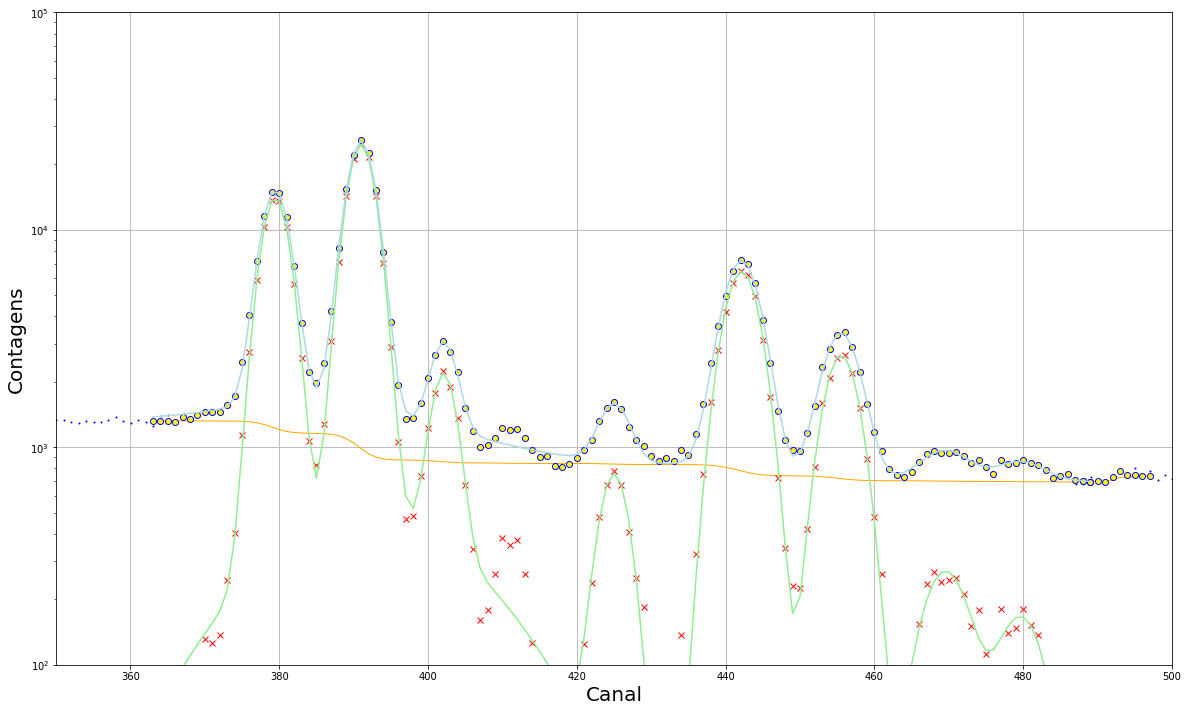

In [43]:
fig5, ax5 = plt.subplots(1, 1, figsize=(20,12))
ax5.grid(True)
ax5.set_xlim(350, 500)
ax5.set_ylim(1e2, 1e5)
ax5.set_xlabel('Canal', size=20)
ax5.set_ylabel('Contagens', size=20)
ax5.semilogy(x_spc, cts_spc, marker='.', markersize=2.0, color='blue', linewidth=0.0)
aaa = [ax5.semilogy(bl[0], bl[1], marker='', markersize=2.0, color='orange', linewidth=1.0) for bl in baselines_inside]
bbb = [ax5.semilogy(nr[0], nr[1], marker='x', color='red', linestyle='None') for nr in net_regions]
ccc = [ax5.semilogy(sm[0], sm[1], marker='o', color='blue', markerfacecolor='yellow', linestyle='None') for sm in soma]
ddd =  ax5.semilogy(net_regions[7][0], gaussian(net_regions[7][0], *popt_gauss1), color='lightgreen')
eee =  ax5.semilogy(net_regions[7][0], gaussian(net_regions[7][0], *popt_gauss1) + baselines_inside[7][1], color='lightblue')

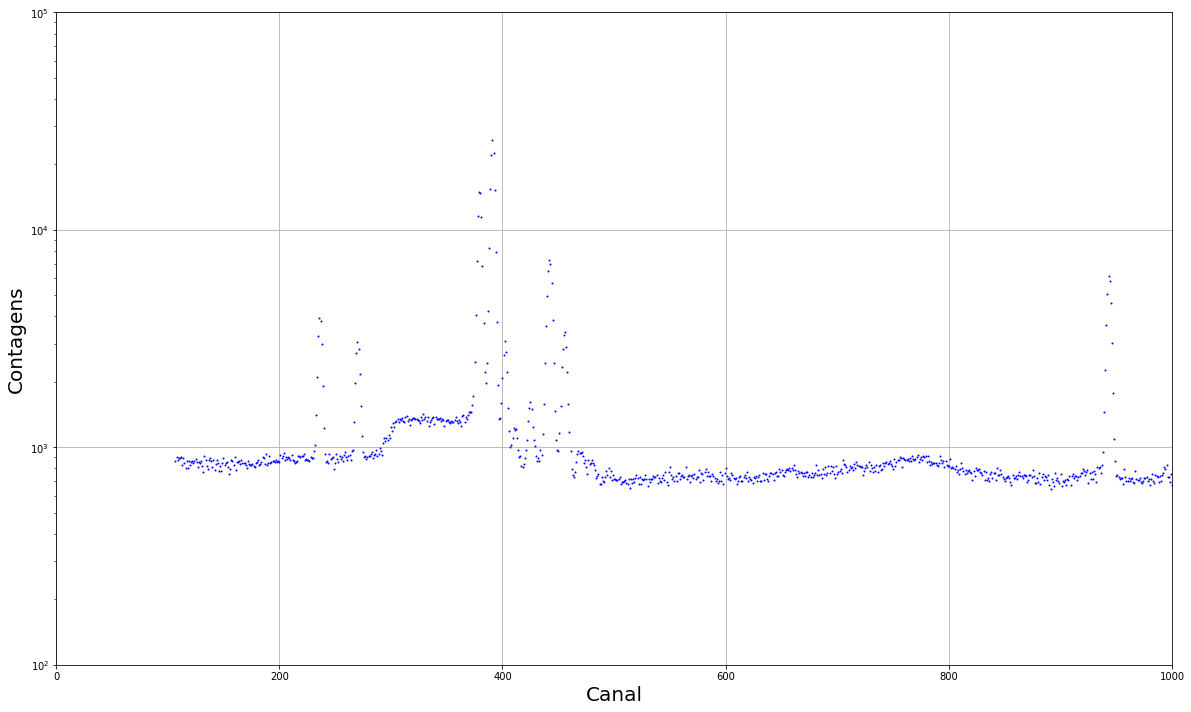

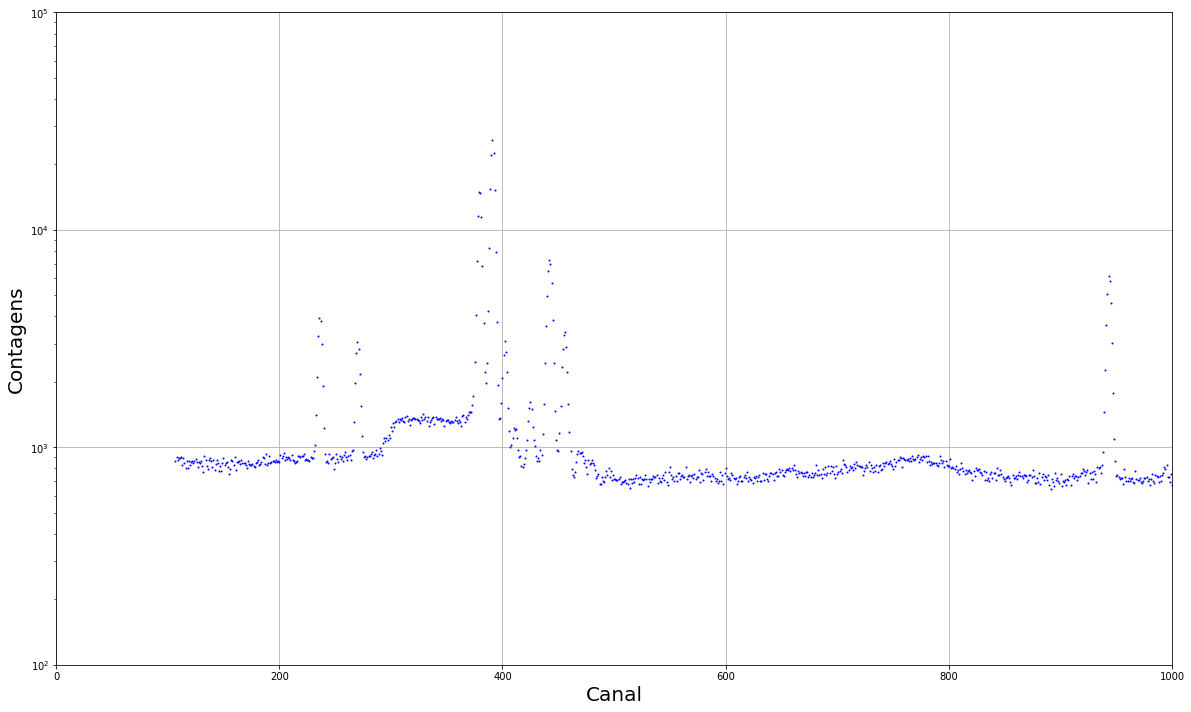

In [44]:
fig5, ax5 = plt.subplots(1, 1, figsize=(20,12))
ax5.semilogy(x_spc, cts_spc, marker='.', markersize=2.0, color='blue', linewidth=0.0)
# ax5.semilogy(x_spc, cts_spc, marker='.', markersize=1.0, color='blue', linewidth=1.0) for i ]
# [ax5.semilogy(x_spc, cts_spc, marker='.', markersize=1.0, color='blue', linewidth=1.0)]
ax5.grid(True)
ax5.set_ylim(1e2, 1e5)
ax5.set_xlabel('Canal', size=20)
ax5.set_ylabel('Contagens', size=20)
ax5.set_xlim(0, 1000)
fig5

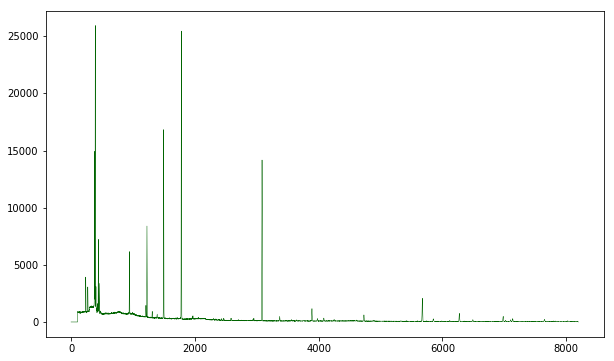

In [45]:
fig1, ax1 = plt.subplots(1, 1, figsize=(10,6))
out1 = ax1.plot(x_spc, cts_spc, color='darkgreen', linewidth='0.5')
# fig1

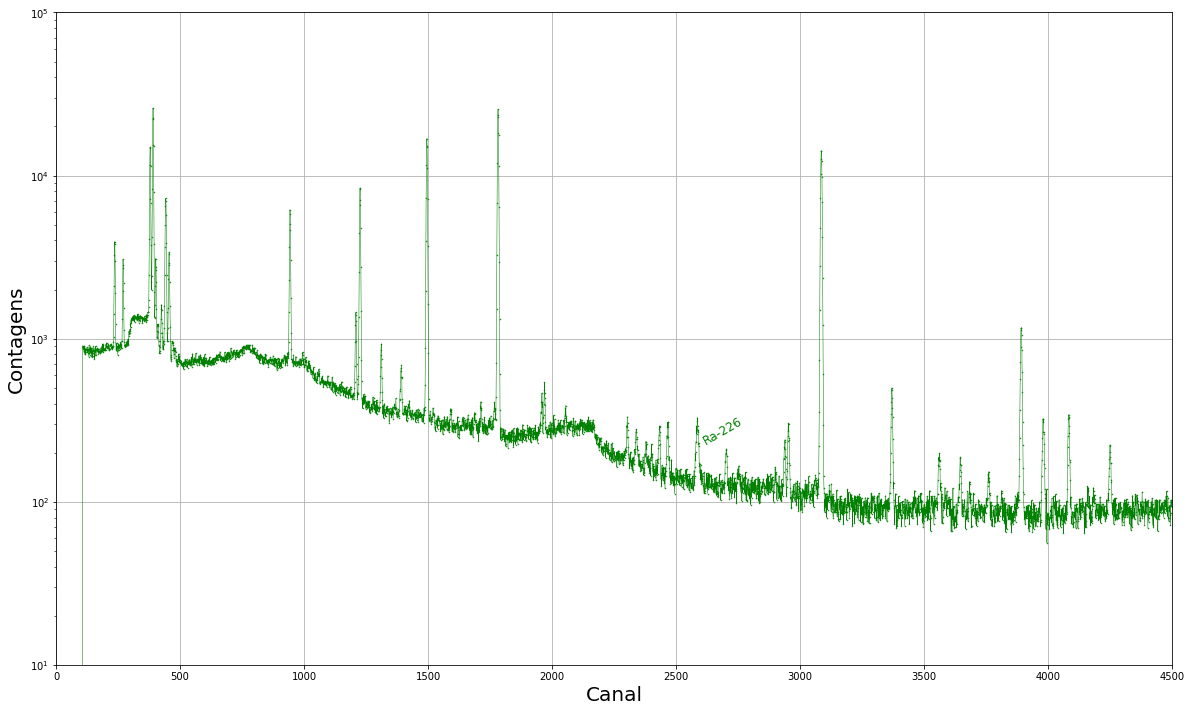

In [46]:
fig5, ax5 = plt.subplots(1, 1, figsize=(20,12))
ax5.semilogy(x_spc, cts_spc, marker='.', markersize=1.0, color='green', linewidth=0.5)
ax5.grid(True)
ax5.set_ylim(1e1, 1e5)
ax5.set_xlabel('Canal', size=20)
ax5.set_ylabel('Contagens', size=20)
ax5.set_xlim(0, 4500)
ax5.text(2600, 300, 'Ra-226', color='green', rotation=30, size=12)
fig5.savefig('fig5.svg')
fig5.savefig('fig5.png')

(0, 1000)

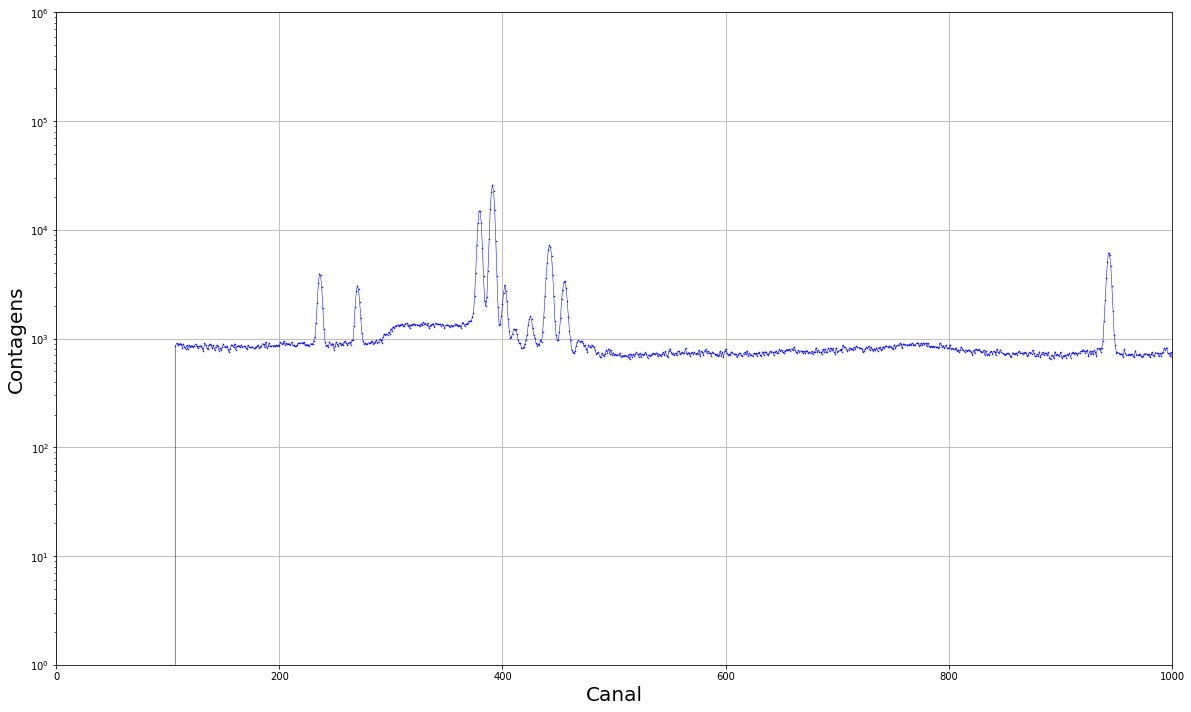

In [47]:
fig5, ax5 = plt.subplots(1, 1, figsize=(20,12))
ax5.semilogy(x_spc, cts_spc, marker='.', markersize=1.0, color='blue', linewidth=0.5)
ax5.grid(True)
ax5.set_ylim(1, 1e6)
ax5.set_xlabel('Canal', size=20)
ax5.set_ylabel('Contagens', size=20)
ax5.set_xlim(0, 1000)
# fig5

In [48]:
blin[17]

[1023, 1037]

In [49]:
x_blin = list(range(blin[17][0], blin[17][1]+1))
print(x_blin)

[1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033, 1034, 1035, 1036, 1037]


In [50]:
x_spc[x_blin]

array([1023.12483221, 1024.12495424, 1025.12507627, 1026.12519829,
       1027.12532032, 1028.12544234, 1029.12556437, 1030.12568639,
       1031.12580842, 1032.12593045, 1033.12605247, 1034.1261745 ,
       1035.12629652, 1036.12641855, 1037.12654057])

In [51]:
fig5, ax5 = plt.subplots(1, 1, figsize=(20,12))
ax5.semilogy(x_spc, cts_spc, marker='.', markersize=1.0, color='blue', linewidth=0.0)
[ax5.semilogy(x_spc, cts_spc, marker='.', markersize=1.0, color='blue', linewidth=1.0) for i ]
[ax5.semilogy(x_spc, cts_spc, marker='.', markersize=1.0, color='blue', linewidth=1.0)]
ax5.grid(True)
ax5.set_ylim(1, 1e6)
ax5.set_xlabel('Canal', size=20)
ax5.set_ylabel('Contagens', size=20)
ax5.set_xlim(0, 1000)
# fig5

SyntaxError: invalid syntax (<ipython-input-51-f2b9f84c7ecc>, line 3)

In [ ]:
ini = 150
fin = 1000
x_part_bl = x_spc[ini:fin]
y_part_bl = bline_estimate( cts_spc[ini:fin] )
wstd_part = [1*x for x in wstd[ini:fin]]

In [ ]:
fig5, ax5 = plt.subplots(1, 1, figsize=(20,12))
ax5.semilogy(x_spc, cts_spc, marker='.', markersize=1.0, color='blue', linewidth=0.5)
ax5.semilogy(x_part_bl, y_part_bl, marker='', markersize=1.0, color='red', linewidth=0.5)
ax5.semilogy(x_part_bl, wstd_part, marker='', markersize=1.0, color='green', linewidth=0.5)
ax5.grid(True)
ax5.set_ylim(1e2, 1e5)
ax5.set_xlabel('Canal', size=20)
ax5.set_ylabel('Contagens', size=20)
ax5.set_xlim(ini, fin)
# fig5